# Transfer Learning on American Sign Language

In [1]:
# set the python env so that we can use the project utils
import sys

sys.path.append("/home/panos/WSL_projects/sign-language-image-detection")

from pprint import pprint

import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tqdm import tqdm

import src.utils.keras_dataset_utils as keras_dataset_utils

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2025-01-13 19:49:08.640866: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736790548.662013    7429 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736790548.666999    7429 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-13 19:49:08.688880: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Num GPUs Available:  1


## Load Dataset

The dataset is structured into folders. Each folder has the name of the `label` and contains all relevant `images` of this label.

Train and Test set are also found into two separate folders.

This allows us to use the `image_dataset_from_directory` method from keras to quickly load the datase.

We __normalize__ the dataset and split it into:

- train set
- validation set (15% of the train set)
- test set


In [2]:
# A quick check to find the dimentionality of the images
from PIL import Image

img = Image.open("/home/panos/WSL_projects/sign-language-image-detection/sign_datasets/american_sign_language_dataset/ASL_Dataset/Train/A/1047.jpg")

print(f'Image dimentions: {img.size}')

Image dimentions: (400, 400)


In [3]:
dataset_path = "/home/panos/WSL_projects/sign-language-image-detection/sign_datasets/american_sign_language_dataset/ASL_Dataset/Train/"

train_dataset, val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    # Resize the image to be compatible with MobileNet
    image_size=(224, 224),
    batch_size=64,
    validation_split=0.15,
    shuffle=True,
    seed=42,
    subset="both",
)

# The test dataset is under the test folder
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path.replace("/Train/", "/Test/"),
    # Resize the image to be compatible with MobileNet
    image_size=(224, 224),
    batch_size=64,
    shuffle=True,
)


def normalize_image(image, label):
    # TODO: Calculate mean, std for the images
    precomputed_mean = [0.52732987, 0.4507709, 0.41209071]
    precomputed_std = [0.19798545, 0.23537221, 0.26049182]

    # Normalize the image
    image = (image / 255.0 - precomputed_mean) / precomputed_std
    return image, label


print(
    f"Train size: {train_dataset.cardinality().numpy()}. Validation size will be: {val_dataset.cardinality().numpy()}"
)

# TODO: Apply normalization
# TODO: Try this https://www.tensorflow.org/api_docs/python/tf/keras/utils/split_dataset

# Set performance settings
# Prefetch one batch at a time
buffer_size = 1
train_dataset = train_dataset.prefetch(buffer_size=buffer_size)
val_dataset = val_dataset.prefetch(buffer_size=buffer_size)
test_dataset = test_dataset.prefetch(buffer_size=buffer_size)


Found 165670 files belonging to 28 classes.
Using 140820 files for training.
Using 24850 files for validation.


I0000 00:00:1736790578.565952    7429 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2859 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1050 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1


Found 112 files belonging to 28 classes.
Train size: 2201. Validation size will be: 389


## Visualizations

Bellow we can see some visualizations for this dataset

100%|██████████| 2201/2201 [15:47<00:00,  2.32it/s]


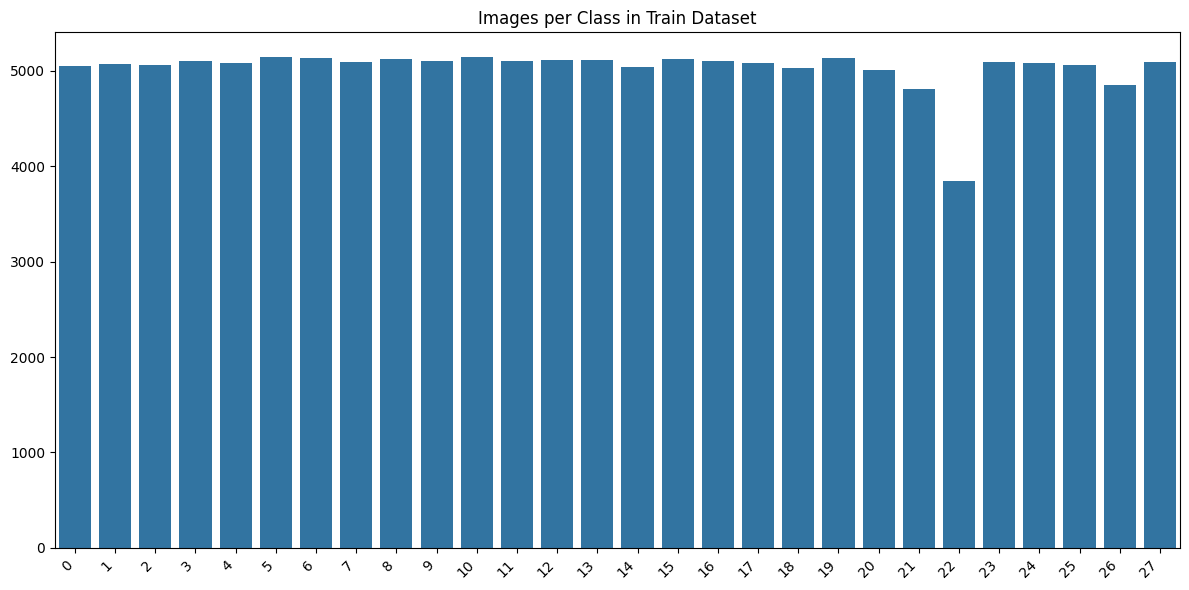

In [4]:
keras_dataset_utils.plot_class_distribution(train_dataset, "Images per Class in Train Dataset")

100%|██████████| 389/389 [00:21<00:00, 17.91it/s]


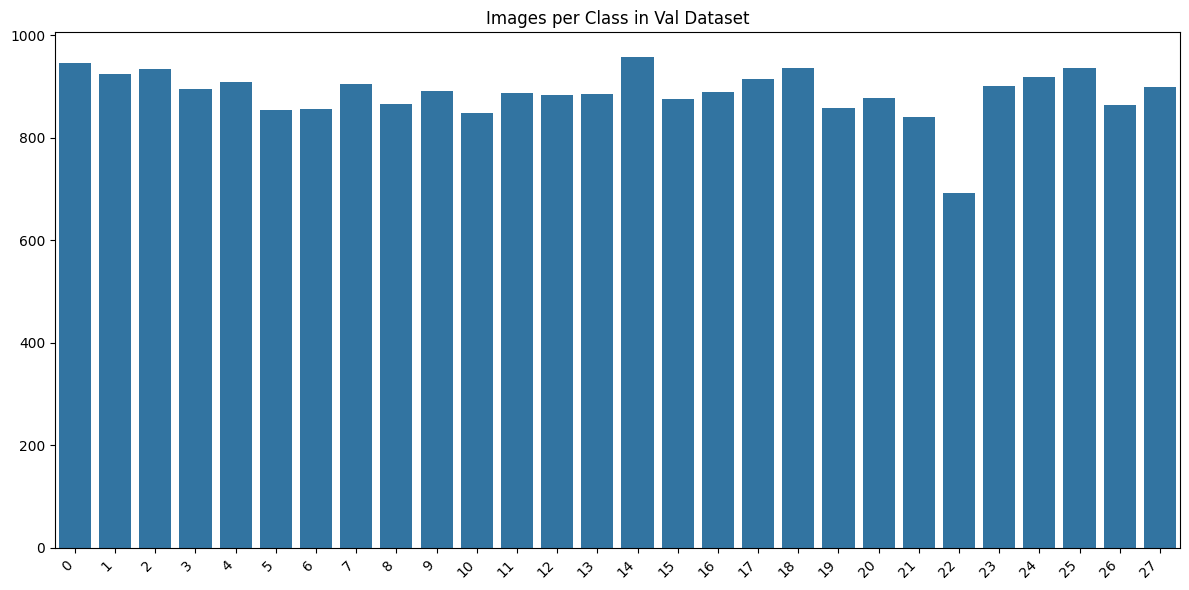

In [5]:
keras_dataset_utils.plot_class_distribution(val_dataset, "Images per Class in Val Dataset")

100%|██████████| 2/2 [00:00<00:00,  7.51it/s]


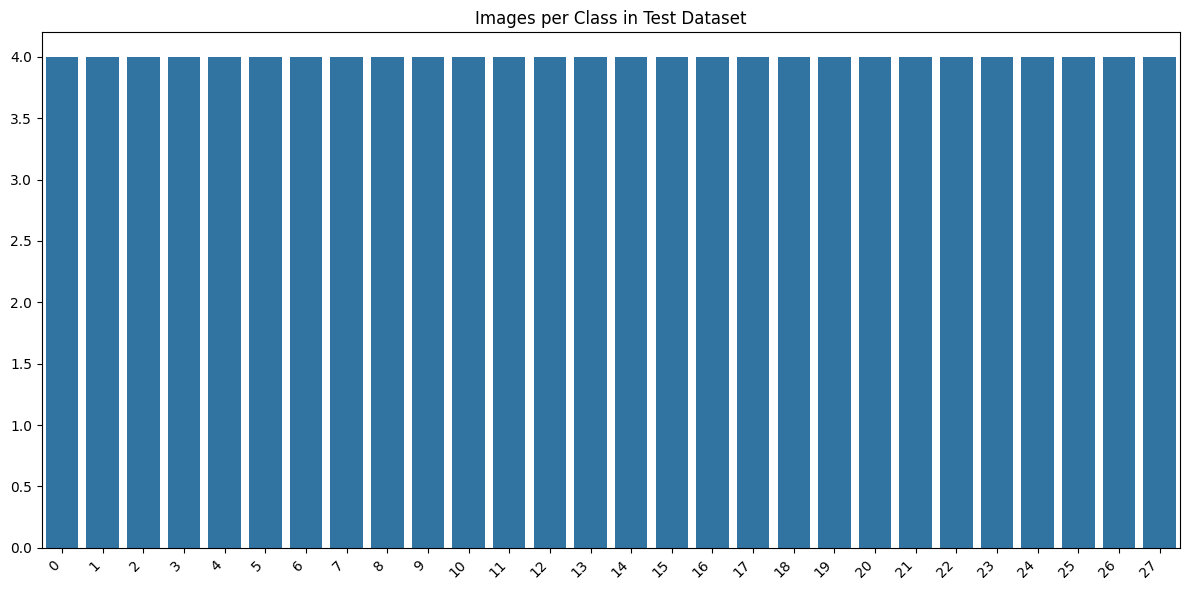

In [6]:
keras_dataset_utils.plot_class_distribution(test_dataset, "Images per Class in Test Dataset")

## Extract Class Names

In [15]:
class_names = set()

for _, labels in test_dataset:
    for label in labels:
        class_names.add(int(label))

print(f'Unique Dataset Labels: {class_names}')

Unique Dataset Labels: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27}


## MobileNet Transfer Learning

Let's try to finetune `MobileNetV2` for our task.

MobileNetV2 is trained on the `imagenet` dataset.

Due to the fact that it works with some specific image sizes, we have to reshape our images from (400, 400) to (224, 244)

In [18]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
# we dont want to train the base model
base_model.trainable = False

# Add custom layers on top of the base model
model = tf.keras.Sequential([
    base_model,
    # This is added to reduce the number of parameters
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(516, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(len(class_names), activation='softmax')
])

print(model.summary())

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_dataset,
                    validation_data=val_dataset,
                    epochs=2)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 516)            │       660,996 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 516)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 28)             │        14,476 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,933,456 (11.19 MB)

 Trainable params: 675,472 (2.58 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

None
Epoch 1/2
2201/2201 ━━━━━━━━━━━━━━━━━━━━ 346s 153ms/step - accuracy: 0.9135 - loss: 0.3101 - val_accuracy: 0.9909 - val_loss: 0.0265
Epoch 2/2
2201/2201 ━━━━━━━━━━━━━━━━━━━━ 334s 152ms/step - accuracy: 0.9888 - loss: 0.0327 - val_accuracy: 0.9961 - val_loss: 0.0111


In [19]:
history

## EfficientNet Transfer Learning

Let's try to finetune `EfficientNetB7` for our task.

EfficientNetB7 is trained on the `imagenet` dataset.

In [20]:
base_model = tf.keras.applications.EfficientNetB7(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
# we dont want to train the base model
base_model.trainable = False

# Add custom layers on top of the base model
model = tf.keras.Sequential([
    base_model,
    # This is added to reduce the number of parameters
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(516, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(len(class_names), activation='softmax')
])

print(model.summary())

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_dataset,
                    validation_data=val_dataset,
                    epochs=1)

258076736/258076736 ━━━━━━━━━━━━━━━━━━━━ 22s 0us/step


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb7 (Functional)     │ (None, 7, 7, 2560)     │    64,097,687 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 2560)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 516)            │     1,321,476 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 516)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 28)             │        14,476 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 65,433,639 (249.61 MB)

 Trainable params: 1,335,952 (5.10 MB)

 Non-trainable params: 64,097,687 (244.51 MB)

None


2025-01-13 22:10:00.866222: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.54GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-01-13 22:10:12.995705: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.23GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-01-13 22:10:13.865332: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.50GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-01-13 22:10:15.108925: W external/local_xla/xla/ts

2200/2201 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9624 - loss: 0.1468

2025-01-13 22:52:50.014978: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 5.33GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-01-13 22:52:50.816377: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 5.46GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


2201/2201 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9624 - loss: 0.1467

2025-01-13 23:01:20.348502: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 5.32GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-01-13 23:01:21.088501: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 5.45GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


2201/2201 ━━━━━━━━━━━━━━━━━━━━ 3165s 1s/step - accuracy: 0.9624 - loss: 0.1467 - val_accuracy: 0.9963 - val_loss: 0.0115
